In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table

Measure = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session= Session(engine)


# Exploratory Climate Analysis

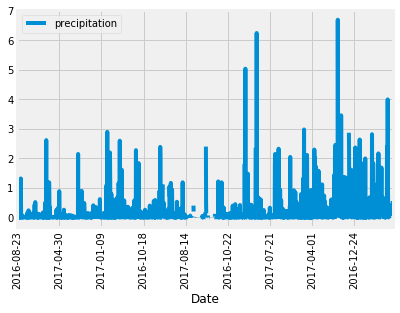

In [10]:
################################### INSTRUTCTIONS ########################################
# ->  Design a query to retrieve the last 12 months of precipitation data and plot the results
# ->  Calculate the date 1 year ago from the last data point in the database
# ->  Perform a query to retrieve the data and precipitation scores
# ->  Save the query results as a Pandas DataFrame and set the index to the date column
# ->  Sort the dataframe by date
# ->  Use Pandas Plotting with Matplotlib to plot the data
#########################################################################################

#------- Taking into consideration that the latest date is  2017-08-23, 
#------- and it is nedeed the last 12 months of precipitation:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#------ the query is created once that the query date is calculated
prep_12 = session.query( Measure.date, Measure.prcp).\
    filter(func.strftime("%Y-%m-%d", Measure.date)>= query_date ).all()

#------ converting the query to pandas
prpc = pd.DataFrame(data = prep_12)
prpc.rename(columns = {"prcp":"precipitation"},inplace = True)
prpc.set_index('date',inplace=True)
prpc.sort_values('date')

#------ Plotting the result
prpc.plot()
plt.xticks(rotation=90)
plt.xlabel("Date")


plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prpc.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Measure.station,func.count(Measure.station).label("Count")).\
    filter(func.strftime("%Y-%m-%d", Measure.date)>= query_date ).\
    group_by(Measure.station).all()

[('USC00513117', 343),
 ('USC00514830', 305),
 ('USC00516128', 349),
 ('USC00517948', 183),
 ('USC00519281', 352),
 ('USC00519397', 361),
 ('USC00519523', 337)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measure.station,func.count(Measure.station).label("Count")).\
    filter(func.strftime("%Y-%m-%d", Measure.date)>= query_date ).\
    group_by(Measure.station).order_by(func.count(Measure.station).label("Count").desc()).all()

[('USC00519397', 361),
 ('USC00519281', 352),
 ('USC00516128', 349),
 ('USC00513117', 343),
 ('USC00519523', 337),
 ('USC00514830', 305),
 ('USC00517948', 183)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Highest observations USC00519397

station = 'USC00519397'

session.query(
        Measure.station,func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)
    ).filter(func.strftime("%Y-%m-%d", Measure.date)>= query_date ).filter(Measure.station==station).all()




[('USC00519397', 60.0, 75.21052631578948, 87.0)]

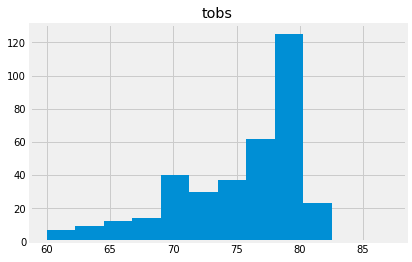

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results
# as a histogram

#------ -> Highest observations USC00519397

high_temp =session.query(Measure.tobs).\
    filter(func.strftime("%Y-%m-%d", Measure.date)>= query_date ).\
    filter(Measure.station==station).all()

tobs = pd.DataFrame(data=high_temp)
tobs.hist(bins=12)
plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
        filter(Measure.date >= start_date).filter(Measure.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = '2016-08-31'
end_date = '2016-09-16'
result = calc_temps(start_date,end_date)
print(
    f'Dates: {start_date} - {end_date} \nTmin: {result[0][0]}\nTavg: {result[0][1]}\nTmax: {result[0][2]}'
)

Dates: 2016-08-31 - 2016-09-16 
Tmin: 71.0
Tavg: 77.64485981308411
Tmax: 84.0


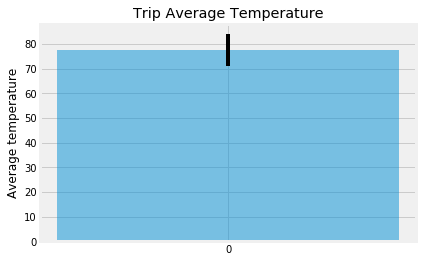

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
result = calc_temps(start_date,end_date)
y_pos = np.arange(1)
yerr = result[0][1]-result[0][2]
height = result[0][1]

plt.bar(y_pos,height,alpha=.5, yerr=yerr)
plt.xticks(y_pos)
plt.ylabel('Average temperature')
plt.title("Trip Average Temperature")
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using 
# the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, 
# name, latitude, longitude, and elevation

session.query(Measure.station,func.sum(Measure.prcp)).\
      filter(Measure.date >= start_date).filter(Measure.date <= end_date).\
      group_by(Measure.station).order_by(func.sum(Measure.prcp).desc()).all()

[('USC00516128', 21.63),
 ('USC00519281', 5.319999999999999),
 ('USC00519523', 3.71),
 ('USC00514830', 3.0599999999999996),
 ('USC00513117', 2.34),
 ('USC00519397', 2.1100000000000003),
 ('USC00517948', 0.0)]

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific
# month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measure.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# 2016-08-31 - 2016-09-16
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip

date_start = dt.date(2016,8,31)
date_end = dt.date(2016,9,16)
# Use the start and end date to create a range of dates
dates_trip = []
for i in range(1,17):
    dates_trip.append(date_start +dt.timedelta(days=i))
  

days =[]
  
# Stip off the year and save a list of %m-%d strings
for i in range(len(dates_trip)):
    days.append(dates_trip[i].strftime("%m-%d"))
    
# Loop through the list of %m-%d strings and calculate the normals for each date
for day in days:
    normals.append(daily_normals(day))
    print(daily_normals(day))



[(69.0, 77.0, 82.0)]
[(67.0, 76.66666666666667, 83.0)]
[(69.0, 76.13725490196079, 83.0)]
[(68.0, 76.27083333333333, 84.0)]
[(66.0, 75.91489361702128, 84.0)]
[(66.0, 74.91111111111111, 81.0)]
[(64.0, 75.18, 82.0)]
[(66.0, 76.22222222222223, 83.0)]
[(68.0, 76.36538461538461, 84.0)]
[(67.0, 76.61224489795919, 85.0)]
[(70.0, 76.69565217391305, 83.0)]
[(68.0, 75.89795918367346, 85.0)]
[(68.0, 75.875, 82.0)]
[(69.0, 75.98076923076923, 85.0)]
[(67.0, 76.14, 81.0)]
[(70.0, 77.40384615384616, 86.0)]
